In [4]:
# Install required packages
!pip install ultralytics
!pip install gradio
!pip install opencv-python-headless
!pip install scikit-learn
!pip install seaborn
!pip install imbalanced-learn

# Import libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import shutil
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from ultralytics import YOLO
import gradio as gr
from PIL import Image
import torch

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("Setup completed successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Setup completed successfully!
PyTorch version: 2.8.0+cu126
CUDA available: False


In [5]:
# Download dataset from Kaggle
# First, upload your kaggle.json file to Colab

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d bhaveshmittal/celebrity-face-recognition-dataset
!unzip -q celebrity-face-recognition-dataset.zip -d celebrity_data

# Define dataset path
dataset_path = 'celebrity_data'

# Function to load and analyze dataset
def load_dataset_info(dataset_path):
    """Load dataset and create information dataframe"""
    data_info = []

    # Assuming structure: dataset_path/celebrity_name/*.jpg
    for celebrity_folder in os.listdir(dataset_path):
        celebrity_path = os.path.join(dataset_path, celebrity_folder)

        if os.path.isdir(celebrity_path):
            images = [f for f in os.listdir(celebrity_path)
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

            for img_name in images:
                img_path = os.path.join(celebrity_path, img_name)
                data_info.append({
                    'celebrity': celebrity_folder,
                    'image_path': img_path,
                    'image_name': img_name
                })

    df = pd.DataFrame(data_info)
    return df
a
# Load dataset
df = load_dataset_info(dataset_path)
print(f"Total images: {len(df)}")
print(f"Number of celebrities: {df['celebrity'].nunique()}")
print(f"\nFirst few rows:")
print(df.head())

cp: cannot stat 'kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/bhaveshmittal/celebrity-face-recognition-dataset
License(s): CC0-1.0
  0% 0.00/34.0M [00:00<?, ?B/s]
100% 34.0M/34.0M [00:00<00:00, 704MB/s]
replace celebrity_data/Angelina Jolie/001_fe3347c0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace celebrity_data/Angelina Jolie/002_8f8da10e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace celebrity_data/Angelina Jolie/003_57612506.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace celebrity_data/Angelina Jolie/004_f61e7d0c.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace celebrity_data/Angelina Jolie/005_582c121a.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace celebrity_data/Angelina Jolie/006_9135205d.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace celebrity_data/Angelina Jolie/007_cabbfcbb.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace celebrity_data/Angelina Jolie/008_d1f87068.jpg? [y]es, [n]o, [A]ll, [N]one, [

Class Distribution:
celebrity
Scarlett Johansson    200
Tom Cruise            100
Tom Hanks             100
Kate Winslet          100
Natalie Portman       100
Hugh Jackman          100
Brad Pitt             100
Will Smith            100
Sandra Bullock        100
Leonardo DiCaprio     100
Angelina Jolie        100
Nicole Kidman         100
Megan Fox             100
Denzel Washington     100
Johnny Depp           100
Robert Downey Jr      100
Jennifer Lawrence     100
Name: count, dtype: int64

Max images per class: 200
Min images per class: 100


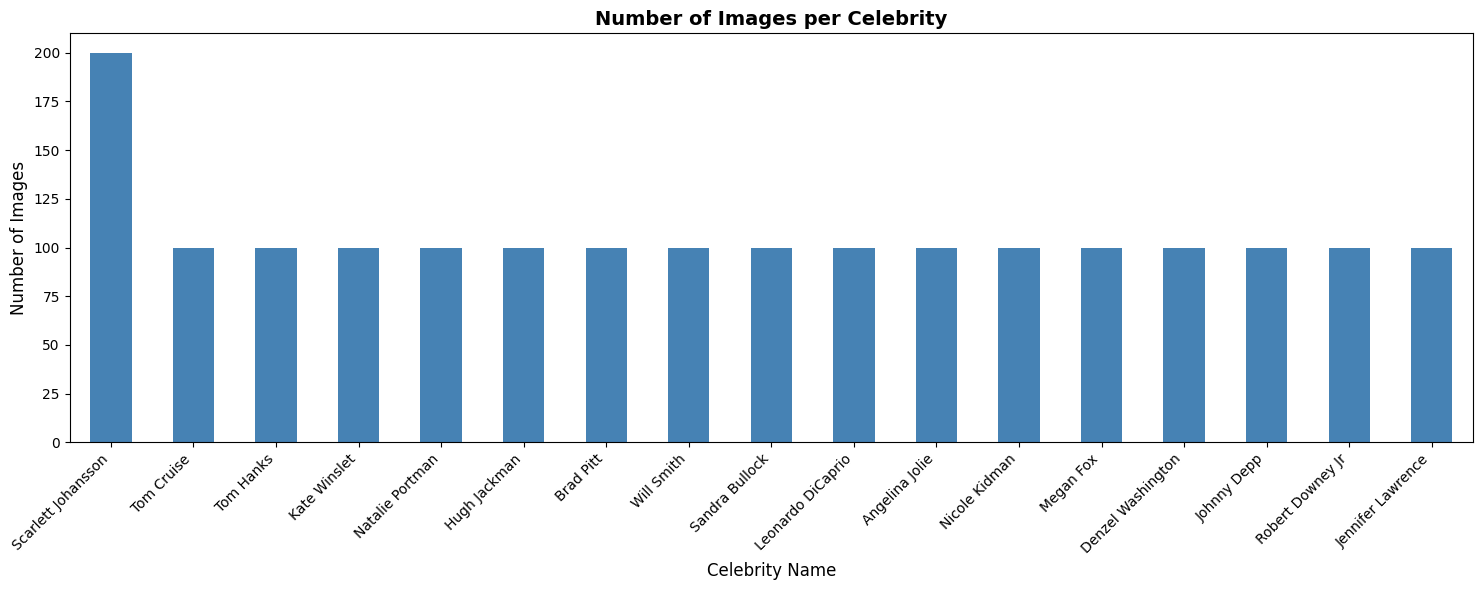


Classes with less than 150 images: 16
celebrity
Tom Cruise           100
Tom Hanks            100
Kate Winslet         100
Natalie Portman      100
Hugh Jackman         100
Brad Pitt            100
Will Smith           100
Sandra Bullock       100
Leonardo DiCaprio    100
Angelina Jolie       100
Nicole Kidman        100
Megan Fox            100
Denzel Washington    100
Johnny Depp          100
Robert Downey Jr     100
Jennifer Lawrence    100
Name: count, dtype: int64


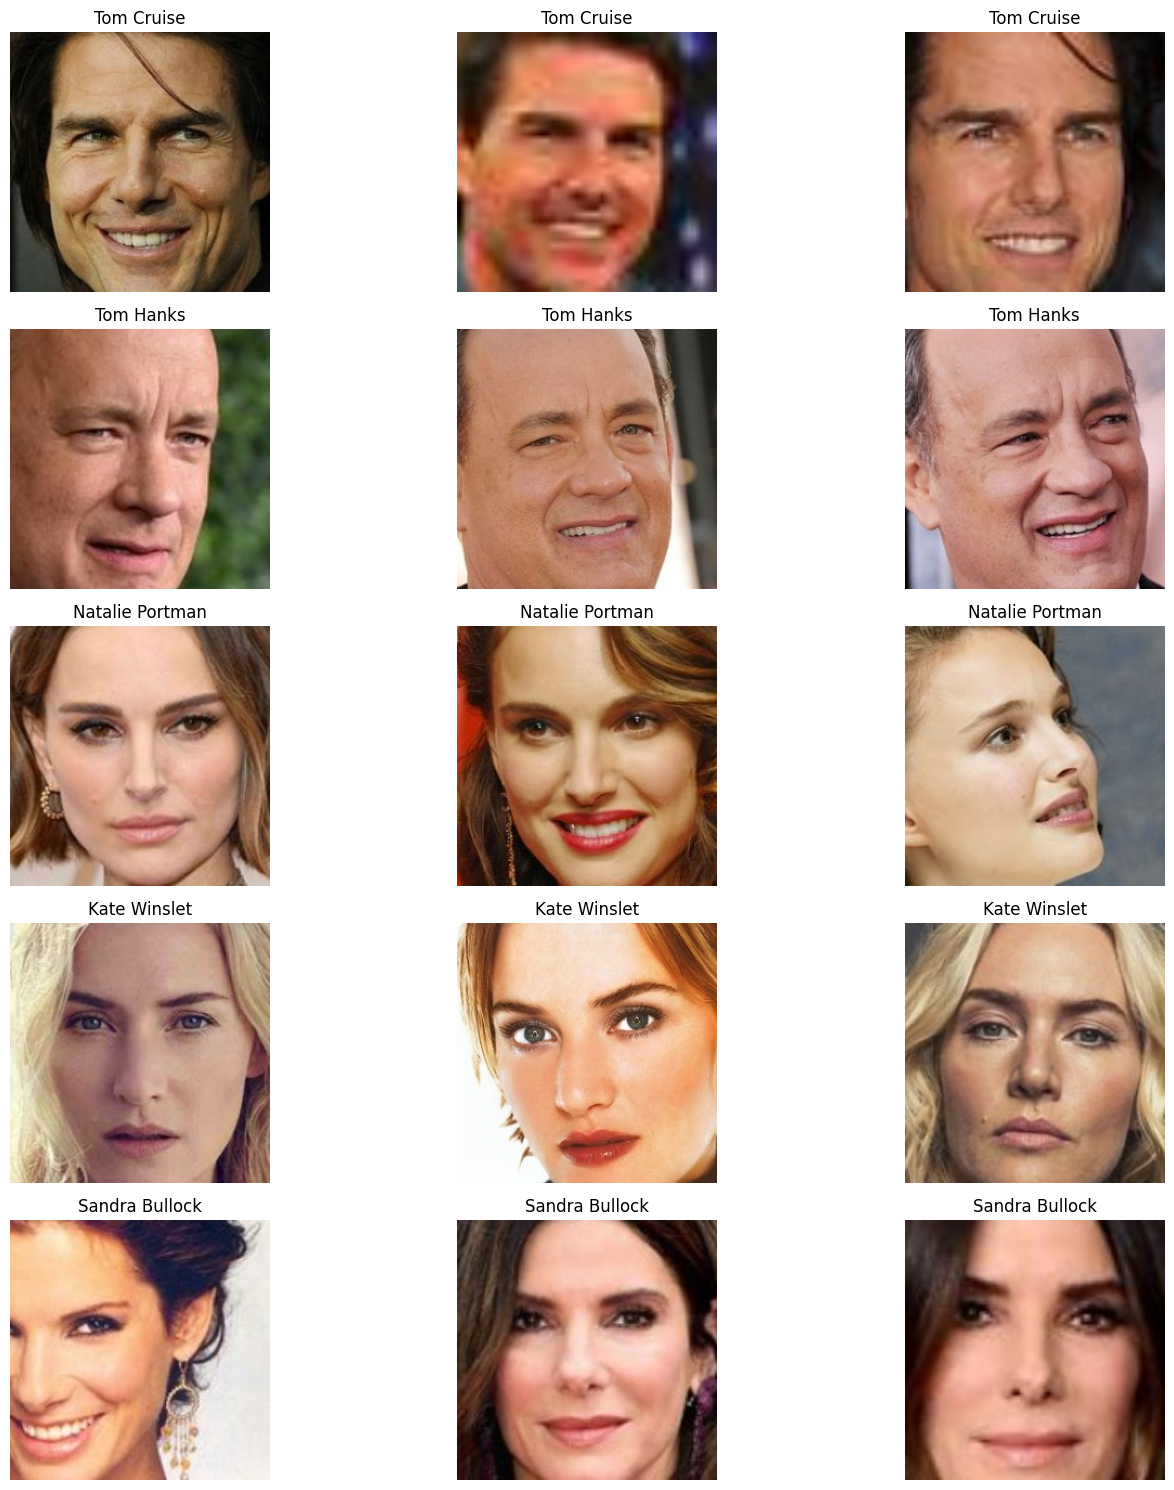


Image Size Statistics:
Average width: 246.85, Average height: 247.91
Min width: 160, Max width: 474
Min height: 190, Max height: 592


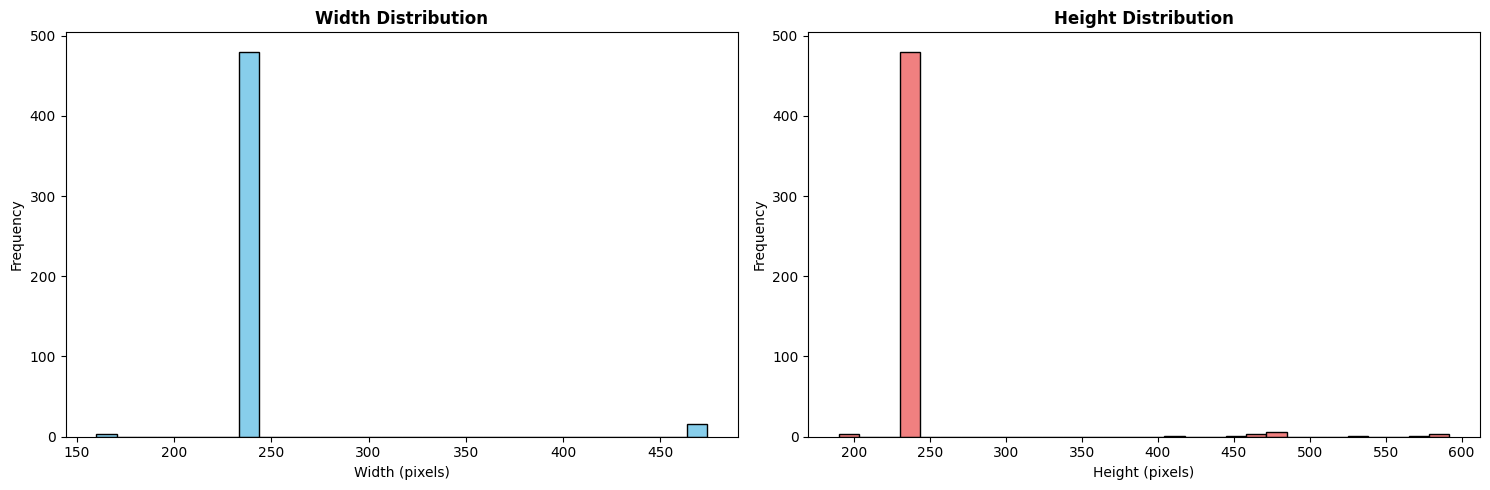

In [6]:
# 1. Class Distribution Analysis
class_counts = df['celebrity'].value_counts()
print("Class Distribution:")
print(class_counts)
print(f"\nMax images per class: {class_counts.max()}")
print(f"Min images per class: {class_counts.min()}")

# 2. Visualize class distribution
plt.figure(figsize=(15, 6))
class_counts.plot(kind='bar', color='steelblue')
plt.title('Number of Images per Celebrity', fontsize=14, fontweight='bold')
plt.xlabel('Celebrity Name', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 3. Check for imbalanced classes
imbalanced_classes = class_counts[class_counts < 150]
print(f"\nClasses with less than 150 images: {len(imbalanced_classes)}")
print(imbalanced_classes)

# 4. Sample images visualization
def show_sample_images(df, num_celebrities=5, images_per_celebrity=3):
    """Display sample images from different celebrities"""
    celebrities = df['celebrity'].unique()[:num_celebrities]

    fig, axes = plt.subplots(num_celebrities, images_per_celebrity,
                             figsize=(15, num_celebrities*3))

    for i, celebrity in enumerate(celebrities):
        celebrity_images = df[df['celebrity'] == celebrity]['image_path'].values
        sample_images = np.random.choice(celebrity_images,
                                        min(images_per_celebrity, len(celebrity_images)),
                                        replace=False)

        for j, img_path in enumerate(sample_images):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            if num_celebrities == 1:
                axes[j].imshow(img)
                axes[j].axis('off')
                axes[j].set_title(f'{celebrity}')
            else:
                axes[i, j].imshow(img)
                axes[i, j].axis('off')
                axes[i, j].set_title(f'{celebrity}')

    plt.tight_layout()
    plt.show()

show_sample_images(df, num_celebrities=5, images_per_celebrity=3)

# 5. Image size analysis
def analyze_image_sizes(df, sample_size=500):
    """Analyze dimensions of images"""
    sample_df = df.sample(min(sample_size, len(df)))
    widths, heights = [], []

    for img_path in sample_df['image_path']:
        img = cv2.imread(img_path)
        if img is not None:
            h, w = img.shape[:2]
            heights.append(h)
            widths.append(w)

    print(f"\nImage Size Statistics:")
    print(f"Average width: {np.mean(widths):.2f}, Average height: {np.mean(heights):.2f}")
    print(f"Min width: {np.min(widths)}, Max width: {np.max(widths)}")
    print(f"Min height: {np.min(heights)}, Max height: {np.max(heights)}")

    # Plot size distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.hist(widths, bins=30, color='skyblue', edgecolor='black')
    ax1.set_title('Width Distribution', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Width (pixels)')
    ax1.set_ylabel('Frequency')

    ax2.hist(heights, bins=30, color='lightcoral', edgecolor='black')
    ax2.set_title('Height Distribution', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Height (pixels)')
    ax2.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

analyze_image_sizes(df)

Classes before filtering: 17
Classes after filtering: 17
Images before: 1800, Images after: 1800

Final distribution:
count     17.0
mean     150.0
std        0.0
min      150.0
25%      150.0
50%      150.0
75%      150.0
max      150.0
Name: count, dtype: float64


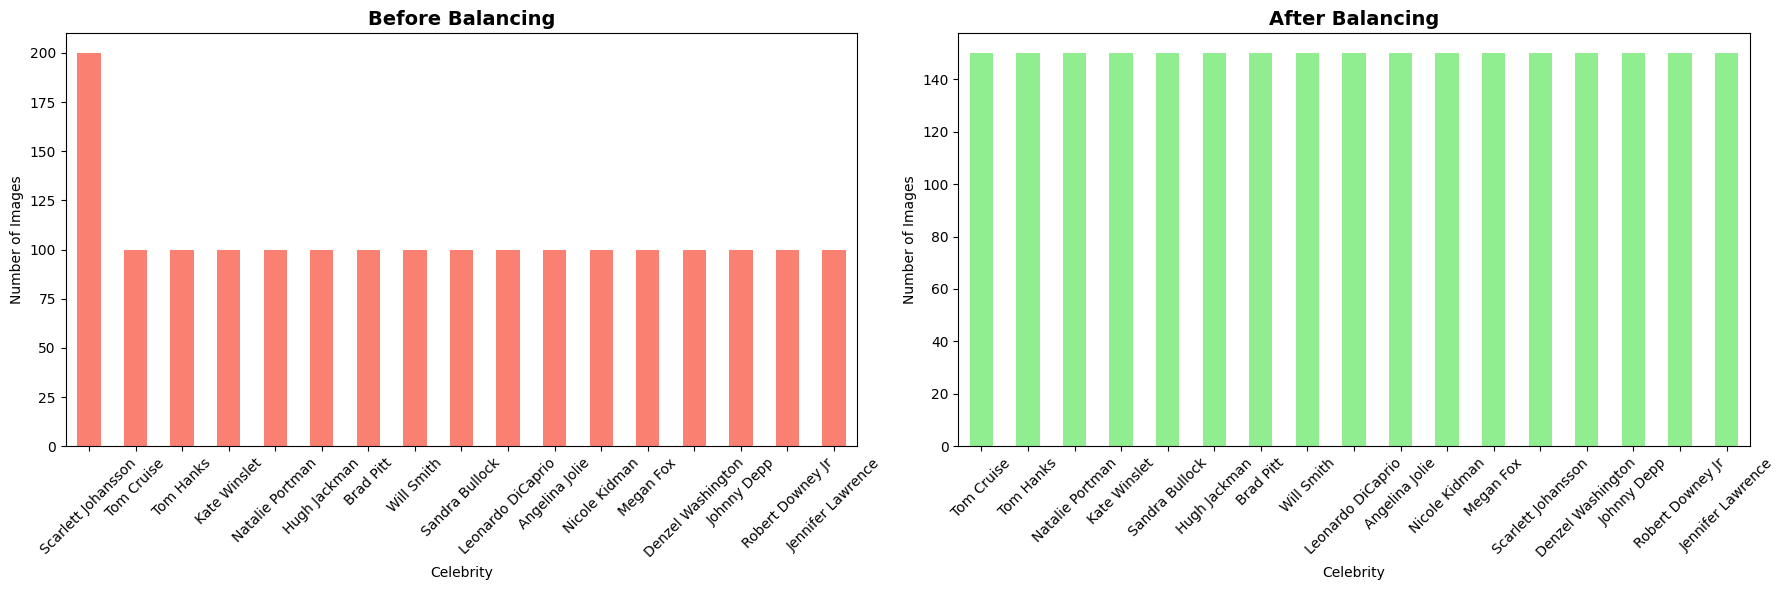


Label mapping created for 17 celebrities
Example mappings: {'Angelina Jolie': 0, 'Brad Pitt': 1, 'Denzel Washington': 2, 'Hugh Jackman': 3, 'Jennifer Lawrence': 4}


In [7]:
# Strategy: Remove classes with very few images, then augment remaining classes

def balance_dataset(df, min_images=100, target_images=150):
    """
    Balance dataset by:
    1. Removing classes with < min_images
    2. Augmenting classes to reach target_images
    """

    # Count images per celebrity
    class_counts = df['celebrity'].value_counts()

    # Step 1: Remove classes with too few images
    valid_classes = class_counts[class_counts >= min_images].index
    df_balanced = df[df['celebrity'].isin(valid_classes)].copy()

    print(f"Classes before filtering: {df['celebrity'].nunique()}")
    print(f"Classes after filtering: {df_balanced['celebrity'].nunique()}")
    print(f"Images before: {len(df)}, Images after: {len(df_balanced)}")

    # Step 2: Augment classes to reach target
    augmented_data = []

    for celebrity in df_balanced['celebrity'].unique():
        celebrity_df = df_balanced[df_balanced['celebrity'] == celebrity]
        current_count = len(celebrity_df)

        if current_count < target_images:
            # Need to augment
            needed = target_images - current_count
            # Duplicate randomly
            augment_df = celebrity_df.sample(n=needed, replace=True)
            augmented_data.append(celebrity_df)
            augmented_data.append(augment_df)
        else:
            # Just take target_images
            sampled_df = celebrity_df.sample(n=target_images, replace=False)
            augmented_data.append(sampled_df)

    df_final = pd.concat(augmented_data, ignore_index=True)

    # Verify balance
    final_counts = df_final['celebrity'].value_counts()
    print(f"\nFinal distribution:")
    print(final_counts.describe())

    # Visualize before and after
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    df['celebrity'].value_counts().plot(kind='bar', ax=ax1, color='salmon')
    ax1.set_title('Before Balancing', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Celebrity')
    ax1.set_ylabel('Number of Images')
    ax1.tick_params(axis='x', rotation=45)

    df_final['celebrity'].value_counts().plot(kind='bar', ax=ax2, color='lightgreen')
    ax2.set_title('After Balancing', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Celebrity')
    ax2.set_ylabel('Number of Images')
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    return df_final

# Apply balancing
df_balanced = balance_dataset(df, min_images=100, target_images=150)

# Create label mapping
label_mapping = {name: idx for idx, name in enumerate(sorted(df_balanced['celebrity'].unique()))}
reverse_mapping = {idx: name for name, idx in label_mapping.items()}

print(f"\nLabel mapping created for {len(label_mapping)} celebrities")
print(f"Example mappings: {dict(list(label_mapping.items())[:5])}")

Train: 1785, Val: 382, Test: 383
Copying training images...
Copying validation images...
Copying test images...

Dataset created at: yolo_dataset

Dataset Split Statistics:
Training samples: 1785 (70.0%)
Validation samples: 382 (15.0%)
Test samples: 383 (15.0%)


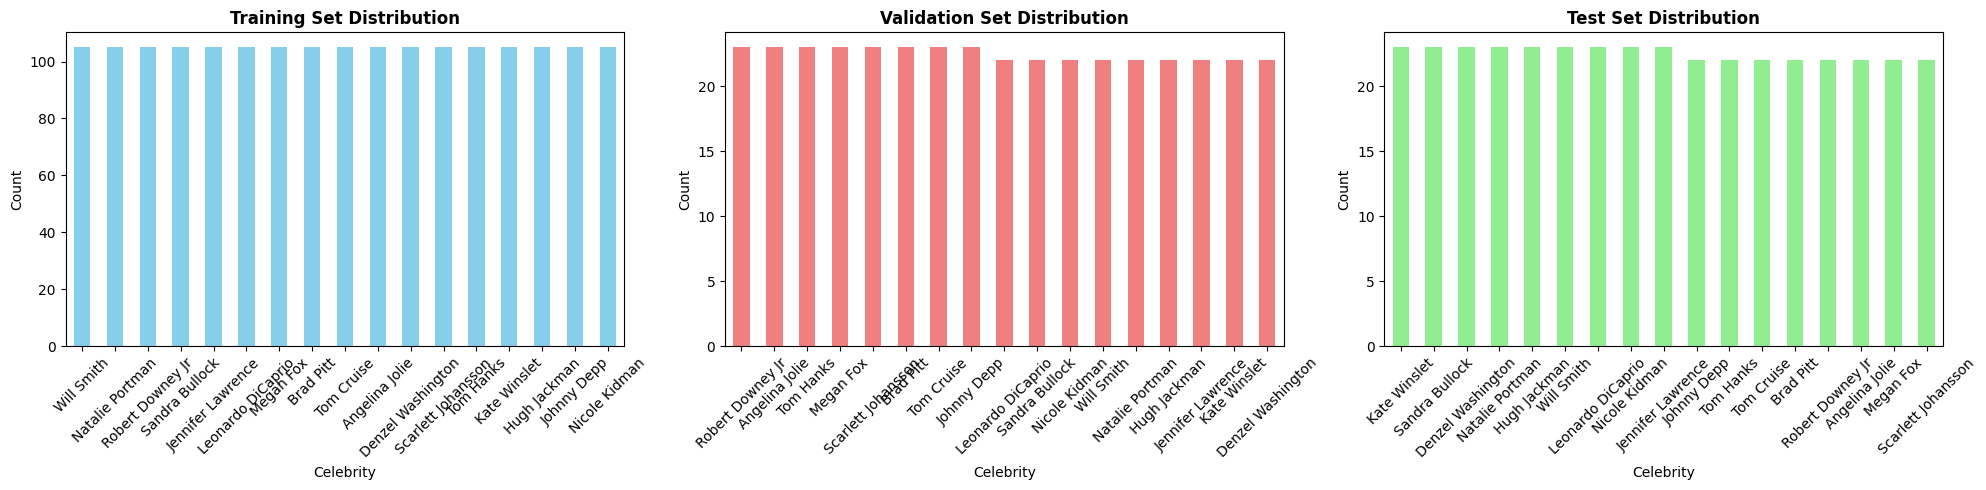

In [8]:
# For face recognition with YOLO, we'll use classification format
# YOLO classification expects: dataset/train/class_name/image.jpg

def create_yolo_classification_dataset(df, output_dir='yolo_dataset', test_size=0.2, val_size=0.1):
    """
    Create YOLO classification format dataset
    """
    # Create directory structure
    for split in ['train', 'val', 'test']:
        split_dir = os.path.join(output_dir, split)
        os.makedirs(split_dir, exist_ok=True)

    # Split data
    train_df, temp_df = train_test_split(df, test_size=(test_size + val_size),
                                         stratify=df['celebrity'], random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=test_size/(test_size + val_size),
                                       stratify=temp_df['celebrity'], random_state=42)

    print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

    # Function to copy images
    def copy_images(df_split, split_name):
        for idx, row in df_split.iterrows():
            celebrity = row['celebrity']
            src_path = row['image_path']

            # Create celebrity folder
            celebrity_dir = os.path.join(output_dir, split_name, celebrity)
            os.makedirs(celebrity_dir, exist_ok=True)

            # Copy image
            dst_path = os.path.join(celebrity_dir, f"{idx}_{row['image_name']}")
            shutil.copy2(src_path, dst_path)

    # Copy images for each split
    print("Copying training images...")
    copy_images(train_df, 'train')
    print("Copying validation images...")
    copy_images(val_df, 'val')
    print("Copying test images...")
    copy_images(test_df, 'test')

    print(f"\nDataset created at: {output_dir}")

    return train_df, val_df, test_df

# Create dataset
train_df, val_df, test_df = create_yolo_classification_dataset(
    df_balanced,
    output_dir='yolo_dataset',
    test_size=0.15,
    val_size=0.15
)

# Display split statistics
print("\nDataset Split Statistics:")
print(f"Training samples: {len(train_df)} ({len(train_df)/len(df_balanced)*100:.1f}%)")
print(f"Validation samples: {len(val_df)} ({len(val_df)/len(df_balanced)*100:.1f}%)")
print(f"Test samples: {len(test_df)} ({len(test_df)/len(df_balanced)*100:.1f}%)")

# Verify class distribution in splits
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

train_df['celebrity'].value_counts().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Training Set Distribution', fontweight='bold')
axes[0].set_xlabel('Celebrity')
axes[0].set_ylabel('Count')

val_df['celebrity'].value_counts().plot(kind='bar', ax=axes[1], color='lightcoral')
axes[1].set_title('Validation Set Distribution', fontweight='bold')
axes[1].set_xlabel('Celebrity')
axes[1].set_ylabel('Count')

test_df['celebrity'].value_counts().plot(kind='bar', ax=axes[2], color='lightgreen')
axes[2].set_title('Test Set Distribution', fontweight='bold')
axes[2].set_xlabel('Celebrity')
axes[2].set_ylabel('Count')

for ax in axes:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [9]:
# Load YOLOv8 pretrained model
model = YOLO("yolov8s-cls.pt")  # Using classification model

# Training configuration
training_args = {
    'data': 'yolo_dataset',
    'epochs': 50,
    'imgsz': 224,
    'batch': 32,
    'patience': 10,
    'save': True,
    'device': 0 if torch.cuda.is_available() else 'cpu',
    'workers': 2,
    'optimizer': 'Adam',
    'lr0': 0.001,
    'lrf': 0.01,
    'momentum': 0.937,
    'weight_decay': 0.0005,
    'warmup_epochs': 3,
    'warmup_momentum': 0.8,
    'warmup_bias_lr': 0.1,
    'box': 7.5,
    'cls': 0.5,
    'dfl': 1.5,
    'hsv_h': 0.015,
    'hsv_s': 0.7,
    'hsv_v': 0.4,
    'degrees': 10.0,
    'translate': 0.1,
    'scale': 0.5,
    'shear': 0.0,
    'perspective': 0.0,
    'flipud': 0.0,
    'fliplr': 0.5,
    'mosaic': 0.0,
    'mixup': 0.0,
    'copy_paste': 0.0,
    'name': 'celebrity_recognition'
}

# Train the model
print("Starting training...")
print(f"Using device: {training_args['device']}")
print(f"Epochs: {training_args['epochs']}")
print(f"Batch size: {training_args['batch']}")
print(f"Image size: {training_args['imgsz']}")

results = model.train(**training_args)

print("\nTraining completed!")
print(f"Best model saved at: runs/classify/celebrity_recognition/weights/best.pt")

Starting training...
Using device: cpu
Epochs: 50
Batch size: 32
Image size: 224
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset, degrees=10.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-cls.pt, momentum=0.937, mosaic=0.0, multi_scale=False, name=celebrity_recognition, nbs=64, nms=False, opset=None, optimize=Fa

In [16]:
import shutil

# نقل الموديل لأبسط مسار
src_path = "/usr/local/lib/python3.12/dist-packages/tests/tmp/runs/classify/celebrity_recognition/weights/best.pt"
dst_path = "/content/best.pt"

shutil.copy(src_path, dst_path)
print("✅ Model saved to:", dst_path)


✅ Model saved to: /content/best.pt


In [17]:
from ultralytics import YOLO

model = YOLO("/content/best.pt")

results = model.val(data="yolo_dataset", split="test")

print("Top-1 Accuracy:", results.top1)
print("Top-5 Accuracy:", results.top5)


Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
YOLOv8s-cls summary (fused): 30 layers, 5,099,539 parameters, 0 gradients, 12.5 GFLOPs
ERROR ❌ train: /content/yolo_dataset/train... found 1785 images in 17 classes (requires 19 classes, not 17)
ERROR ❌ val: /content/yolo_dataset/val... found 382 images in 17 classes (requires 19 classes, not 17)
ERROR ❌ test: /content/yolo_dataset/test... found 383 images in 17 classes (requires 19 classes, not 17)
test: Fast image access ✅ (ping: 0.1±0.0 ms, read: 2.5±2.0 MB/s, size: 17.9 KB)
test: Scanning /content/yolo_dataset/test... 383 images, 0 corrupt: 100% ━━━━━━━━━━━━ 383/383 683.0it/s 0.6s
test: New cache created: /content/yolo_dataset/test.cache
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 24/24 1.3it/s 18.2s
                   all      0.961       0.99
Speed: 0.0ms preprocess, 42.0ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /usr/local/lib/python3.12/dist-pack


image 1/1 /content/celebrity_data/Tom Cruise/001_08212dcd.jpg: 224x224 Tom Cruise 1.00, Robert Downey Jr 0.00, Sandra Bullock 0.00, Hugh Jackman 0.00, Leonardo DiCaprio 0.00, 51.9ms
Speed: 3.8ms preprocess, 51.9ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


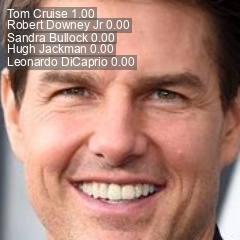

ultralytics.engine.results.Probs object with attributes:

data: tensor([3.2471e-10, 5.0075e-10, 2.0579e-09, 1.4409e-08, 1.7644e-11, 3.4686e-10, 1.2991e-09, 1.0346e-08, 2.2496e-11, 4.4582e-09, 1.0895e-10, 6.7640e-08, 2.1598e-08, 2.1813e-11, 1.0000e+00, 2.6627e-10, 4.0044e-11, 1.1603e-11, 1.0468e-11])
orig_shape: None
shape: torch.Size([19])
top1: 14
top1conf: tensor(1.0000)
top5: [14, 11, 12, 3, 7]
top5conf: tensor([1.0000e+00, 6.7640e-08, 2.1598e-08, 1.4409e-08, 1.0346e-08])


In [19]:
from IPython.display import Image, display

img_path = "/content/celebrity_data/Tom Cruise/001_08212dcd.jpg"

results = model(img_path)
results[0].show()

print(results[0].probs)


Saving download (6).jpeg to download (6).jpeg
Image uploaded: download (6).jpeg

image 1/1 /content/download (6).jpeg: 512x640 2 persons, 1 tie, 253.4ms
Speed: 23.3ms preprocess, 253.4ms inference, 12.8ms postprocess per image at shape (1, 3, 512, 640)


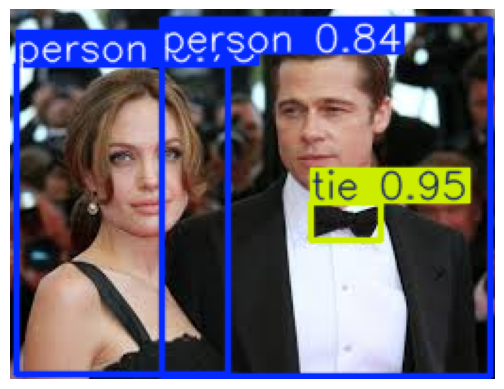

In [21]:

from ultralytics import YOLO
from google.colab import files
import cv2
from matplotlib import pyplot as plt

uploaded = files.upload()

image_path = list(uploaded.keys())[0]
print("Image uploaded:", image_path)

model = YOLO("yolov8n.pt")

results = model.predict(source=image_path, conf=0.5)

result_img = results[0].plot()
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


Saving download (6).jpeg to download (6) (1).jpeg
✅ Image uploaded: download (6) (1).jpeg
--2025-11-04 18:20:29--  https://github.com/akanametov/yolov8-face/releases/download/v0.0.0/yolov8n-face.pt
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/YapaLab/yolo-face/releases/download/v0.0.0/yolov8n-face.pt [following]
--2025-11-04 18:20:29--  https://github.com/YapaLab/yolo-face/releases/download/v0.0.0/yolov8n-face.pt
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/592261808/fef886fa-7bce-42bc-8056-4c0ee291b0eb?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-11-04T19%3A04%3A18Z&rscd=attachment%3B+filename%3Dyolov8n-face.pt&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&skt

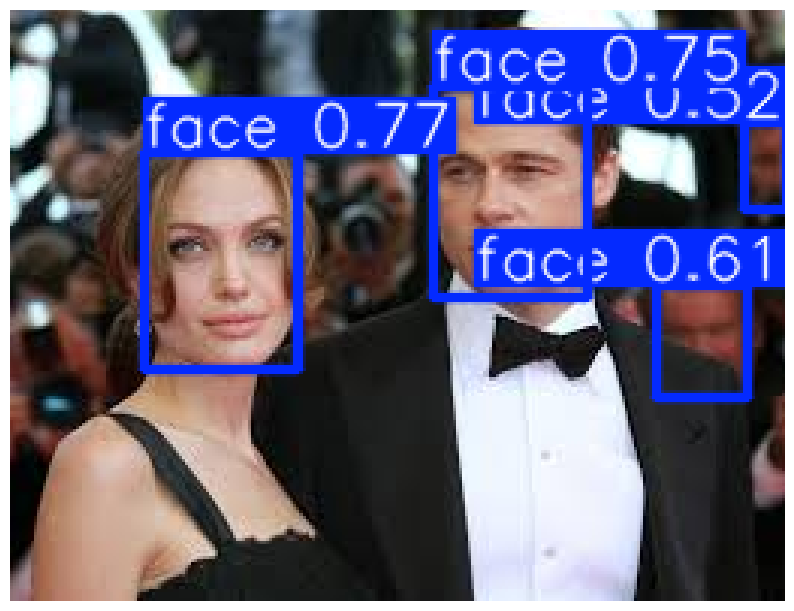

In [22]:

from ultralytics import YOLO
from google.colab import files
import cv2
from matplotlib import pyplot as plt

uploaded = files.upload()

image_path = list(uploaded.keys())[0]
print("✅ Image uploaded:", image_path)

!wget -O yolov8n-face-alt.pt https://github.com/akanametov/yolov8-face/releases/download/v0.0.0/yolov8n-face.pt

model = YOLO("yolov8n-face-alt.pt")

results = model.predict(source=image_path, conf=0.5)

result_img = results[0].plot()
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [28]:

from ultralytics import YOLO
import cv2
import numpy as np
import gradio as gr

face_model = YOLO("https://github.com/akanametov/yolov8-face/releases/download/v0.0.0/yolov8n-face.pt")  # face detector
clf_model = YOLO("/content/best.pt")  # موديلك للتصنيف

def recognize_faces(image):
    img_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    faces = face_model.predict(source=img_bgr, conf=0.5, verbose=False)

    if len(faces[0].boxes) == 0:
        return image, "🚫 No face detected"

    annotated = img_bgr.copy()
    results_text = []

    for box in faces[0].boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        face_crop = img_bgr[y1:y2, x1:x2]

        if face_crop.size == 0:
            continue
        result = clf_model.predict(source=face_crop, verbose=False)

        label = result[0].names[int(result[0].probs.top1)]
        conf = float(result[0].probs.top1conf)
        results_text.append(f"{label} ({conf:.2f})")

        cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(annotated, f"{label} {conf:.2f}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
    summary = "\n".join(results_text)

    return annotated_rgb, summary

iface = gr.Interface(
    fn=recognize_faces,
    inputs=gr.Image(type="numpy", label="Upload Image"),
    outputs=[gr.Image(type="numpy", label="Detected Faces"), gr.Textbox(label="Predictions")],
    title="🎭 YOLO Face Recognition App",
    description="Upload an image to detect and recognize faces using YOLOv8 models.",
)

iface.launch(debug=True)


Found https://github.com/akanametov/yolov8-face/releases/download/v0.0.0/yolov8n-face.pt locally at weights/yolov8n-face.pt
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://0fcada162c9a1784b7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1134, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://5ff4c7c33139fb4aee.gradio.live
Killing tunnel 127.0.0.1:7861 <> https://09068cd38a702fad72.gradio.live
Killing tunnel 127.0.0.1:7862 <> https://8a61b517455685cdfc.gradio.live
Killing tunnel 127.0.0.1:7863 <> https://0fcada162c9a1784b7.gradio.live


In [30]:

from ultralytics import YOLO
import cv2
import numpy as np
import gradio as gr
import tempfile
from moviepy.editor import VideoFileClip

face_model = YOLO("https://github.com/akanametov/yolov8-face/releases/download/v0.0.0/yolov8n-face.pt")  # face detector
clf_model = YOLO("/content/best.pt")

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    output_path = tempfile.NamedTemporaryFile(suffix=".mp4", delete=False).name
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        faces = face_model.predict(source=frame, conf=0.5, verbose=False)

        for box in faces[0].boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            face_crop = frame[y1:y2, x1:x2]

            if face_crop.size == 0:
                continue

            result = clf_model.predict(source=face_crop, verbose=False)
            label = result[0].names[int(result[0].probs.top1)]
            conf = float(result[0].probs.top1conf)

            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, f"{label} {conf:.2f}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

        out.write(frame)

    cap.release()
    out.release()

    clip = VideoFileClip(output_path)
    final_path = tempfile.NamedTemporaryFile(suffix=".mp4", delete=False).name
    clip.write_videofile(final_path, codec='libx264', audio=False, verbose=False, logger=None)
    return final_path

iface = gr.Interface(
    fn=process_video,
    inputs=gr.Video(label="🎥 Upload a Video"),
    outputs=gr.Video(label="🧠 Recognized Faces Video"),
    title="YOLOv8 Face Recognition (Video Mode)",
    description="Upload a video to detect and recognize faces frame-by-frame using YOLOv8.",
)

iface.launch(share=True, debug=False)


Found https://github.com/akanametov/yolov8-face/releases/download/v0.0.0/yolov8n-face.pt locally at weights/yolov8n-face.pt
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5f0100574ded0fd195.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [31]:
!pip freeze > requirements.txt


In [32]:
from google.colab import files
files.download('requirements.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>